In [2]:
import tensorflow as tf

tf.config.list_physical_devices()



[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [1]:
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)


2.20.0
3.13.2


In [2]:
import kagglehub
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print(path)


ModuleNotFoundError: No module named 'kagglehub'

In [ ]:
import os
base_dir = os.path.join(path, "chest_xray")
os.listdir(base_dir)

train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")
test_dir  = os.path.join(base_dir, "test")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
ImageSize=(224,224)
BatchSize=16

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

In [ ]:
val_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)

In [ ]:
train_data=train_datagen.flow_from_directory(
    train_dir,
    target_size=ImageSize,
    batch_size=BatchSize,
    class_mode='binary'
)

test_data=test_datagen.flow_from_directory(
    test_dir,
    target_size=ImageSize,
    batch_size=BatchSize,
    class_mode='binary',
    shuffle=False
)

val_data=val_datagen.flow_from_directory(
    val_dir,
    target_size=ImageSize,
    batch_size=BatchSize,
    class_mode='binary'
)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
labels = train_data.classes
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))


{np.int32(0): np.int64(1341), np.int32(1): np.int64(3875)}


In [ ]:
# “Mistakes on NORMAL are ~3× more costly.”
class_weight={
    0:3875/1341,
    1:1.0
}

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam


In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3),use_bias=False),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu',use_bias=False),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu',use_bias=False),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall()]
)


In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    class_weight=class_weight
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 130s 375ms/step - accuracy: 0.8462 - loss: 1.2546 - recall: 0.8490 - val_accuracy: 0.5000 - val_loss: 8.6434 - val_recall: 1.0000
Epoch 2/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 100s 305ms/step - accuracy: 0.9126 - loss: 0.3557 - recall: 0.9076 - val_accuracy: 0.6875 - val_loss: 0.7808 - val_recall: 1.0000
Epoch 3/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 100s 307ms/step - accuracy: 0.9202 - loss: 0.3159 - recall: 0.9156 - val_accuracy: 0.7500 - val_loss: 0.5350 - val_recall: 0.5000
Epoch 4/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 101s 310ms/step - accuracy: 0.9231 - loss: 0.3023 - recall: 0.9220 - val_accuracy: 1.0000 - val_loss: 0.1195 - val_recall: 1.0000
Epoch 5/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 100s 306ms/step - accuracy: 0.9321 - loss: 0.2756 - recall: 0.9325 - val_accuracy: 0.8750 - val_loss: 0.2792 - val_recall: 1.0000
Epoch 6/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 100s 308ms/step - accuracy: 0.9203 - loss: 0.3340 - recall: 0.9120 - val_accuracy: 0.6250 - val_loss: 2.3955 -

In [ ]:
model.evaluate(test_data)

39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9139 - loss: 0.2712 - recall: 0.5972


[0.2655530571937561, 0.9022436141967773, 0.9051281809806824]

In [ ]:
import numpy as np

preds = model.predict(test_data).ravel()
y_true = test_data.classes

for t in [0.2, 0.3, 0.4, 0.5]:
    y_pred = (preds > t).astype(int)
    recall = np.sum((y_pred==1) & (y_true==1)) / np.sum(y_true==1)
    print(f"threshold {t} → recall {recall:.3f}")


39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step
threshold 0.2 → recall 0.964
threshold 0.3 → recall 0.941
threshold 0.4 → recall 0.926
threshold 0.5 → recall 0.905


In [ ]:
THRESHOLD =0.2

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step
[[186  48]
 [ 14 376]]


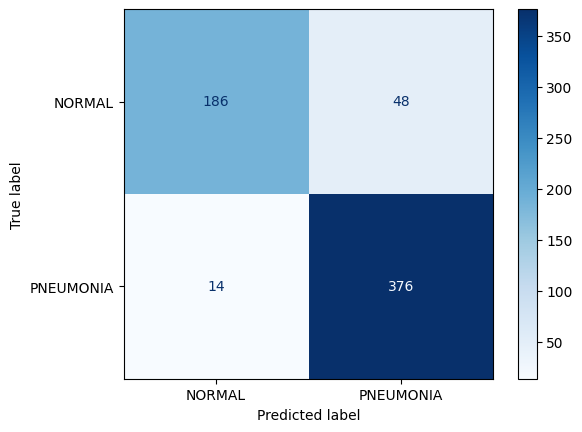

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

preds = model.predict(test_data).ravel()
y_true = test_data.classes
y_pred = (preds > 0.2).astype(int)

cm = confusion_matrix(y_true, y_pred)
print(cm)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["NORMAL", "PNEUMONIA"]
)
disp.plot(cmap="Blues")
plt.show()


In [ ]:
model.save("pneumonia_model.keras")